In [1]:
#Import Libraries, read file, add column names and drop all but the review column
#I reduced the dataset from 157836 tuples to 50000 due to processing constraints
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
plt.style.use ('fivethirtyeight')
import json
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

data = getDF(r'C:\Users\julie\Desktop\d213\reviews_Pet_Supplies_5.json.gz')  
data.drop(data.tail(107836).index,inplace = True)
data.shape

(50000, 9)

In [2]:
#preprocesssing by changing text to lower case and removing punctuation 
#Source (Ngyptr, LSTM Sentiment Analysis: Keras 2018)
data['summary'] = data['summary'].apply(lambda x: x.lower())
data['summary'] = data['summary'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

In [3]:
#Remove stopwords because they do not contribute to the sentiment
#Source (Ngyptr, LSTM Sentiment Analysis: Keras 2018)
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(data):
    return " ".join([word for word in str(data).split() if word not in STOPWORDS])
data['nostoptext'] = data['summary'].apply(lambda data: remove_stopwords(data))

In [4]:
#preprocessing - apply lemmatizer to reduce words to their root so they can be grouped
#Source (Ngyptr, LSTM Sentiment Analysis: Keras 2018)
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(data):
    pos_tagged_data = nltk.pos_tag(data.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_data])
data['lemmatext'] = data['nostoptext'].apply(lambda data: lemmatize_words(data))
#data.head()

In [5]:
#Find the maximum number of characters in a review
#Source (Ngyptr, LSTM Sentiment Analysis: Keras 2018)
data['summary']=data['summary'].apply(len)
column = data['summary']
max_value = column.max()
max_value

126

In [6]:
#finding unique number of words
#Source (Ngyptr, LSTM Sentiment Analysis: Keras 2018)
text=data['lemmatext']
unique = []
for word in text:
    if word not in unique:
        unique.append(word)
len(unique)

31719

In [7]:
#split the data into words, change to values and pad so they are the same length
#Source (Ngyptr, LSTM Sentiment Analysis: Keras 2018)
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(text)
sequences=tokenizer_obj.texts_to_sequences(text)
pad=pad_sequences(sequences,maxlen=128,truncating='post',padding='post')
pad

array([[  15, 1602,    4, ...,    0,    0,    0],
       [ 344,    4,    0, ...,    0,    0,    0],
       [ 344,    0,    0, ...,    0,    0,    0],
       ...,
       [ 375,    0,    0, ...,    0,    0,    0],
       [   6,    0,    0, ...,    0,    0,    0],
       [2531,   60, 1884, ...,    0,    0,    0]])

In [8]:
#Pad the data so that X and Y are the same width
Y=data[['overall']]
Y = str(Y)
Y.rjust(128, '0')
Y= np.asarray(pad).astype(np.float32)
Y.shape 

(50000, 128)

In [9]:
#split the data into training and testing
#Source (Twitter Sentiment Analysis Using Python 2020)
X_train, X_test, Y_train, Y_test = train_test_split(pad,Y, test_size = 0.4, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(30000, 128) (30000, 128)
(20000, 128) (20000, 128)


In [10]:
#create the model
#Source (Ngyptr, LSTM Sentiment Analysis: Keras 2018)
model = Sequential()
model.add(Embedding(64000, 32,input_length=128))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(128,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 32)           2048000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 128, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
Total params: 2,146,944
Trainable params: 2,146,944
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
#fit the model
#Source (Twitter Sentiment Analysis Using Python 2020)
from keras.callbacks import EarlyStopping, ModelCheckpoint
#callbacks = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,mode='min')
#callbacks = ModelCheckpoint('../best_weight_glove_bi_100d.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
#callback=EarlyStopping(monitor='loss', mode='min', verbose=1)
history=model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=8, verbose=0, callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=.25, patience=2, cooldown=0)]
)

In [21]:
#Evaluate metrics to determine quality of the model
#Source (Ngyptr, LSTM Sentiment Analysis: Keras 2018)
loss, accuracy = model.evaluate(X_train,Y_train, verbose=2)
print('Accuracy: %f' % (accuracy*100))

938/938 - 30s - loss: 135134.0625 - accuracy: 0.3316
Accuracy: 33.160001


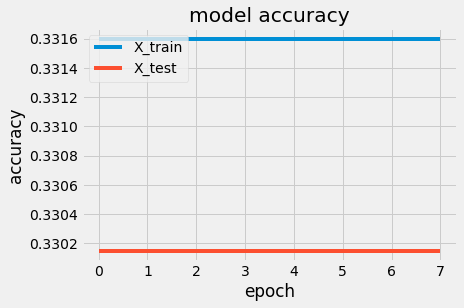

In [23]:
#plot accuracy vs epoch and loss vs. epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['X_train', 'X_test'], loc='upper left')
plt.show() 

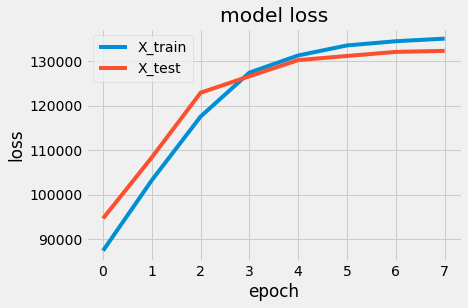

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['X_train', 'X_test'], loc='upper left')
plt.show()

In [74]:
data.to_csv('D213Task2Pet.csv')